In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm_notebook as tqdm
from keras_tqdm import TQDMNotebookCallback
import matplotlib.image as mpimg
import warnings
import keras.backend as K
%matplotlib inline
warnings.filterwarnings('ignore')

In [19]:
# Get images
imWidth = 224
nbImages = 20
y = []
i = 0
with open("coloredImages.txt") as f:    
    for filename in tqdm(f.readlines()[:nbImages]):
        filename = filename.rstrip()
        filename += ".jpg"
        img = cv2.resize(
            mpimg.imread('data/images/'+filename),
            dsize=(imWidth, imWidth),
            interpolation=cv2.INTER_CUBIC
        )
        y.append(img)
y = np.array(y)
print(y.shape)

(20, 224, 224, 3)


In [20]:
# Transform img to Grayscale
X = []
for img in tqdm(y):
    X.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
X = np.array(X)
print(X.shape)

(20, 224, 224)


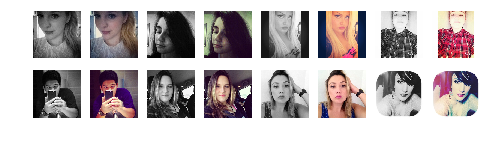

In [21]:
columns = 8
rows = 2
fig=plt.figure(figsize=(columns, rows))
for i in range(1, columns*rows +1,2):
    fig.add_subplot(rows, columns, i)
    plt.imshow(X[i-1], cmap='gray')
    plt.axis('off')
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(y[i-1])
    plt.axis('off')
plt.show()

In [22]:
X_reshaped = X.reshape(X.shape[0],imWidth,imWidth,1)
X_scaled = X_reshaped / 255
y_scaled = y / 255
print(np.max(X_scaled))
print(np.max(y_scaled))
print(X_scaled.shape)
X_conc = np.concatenate([X_scaled, X_scaled, X_scaled], axis=3)
print(X_conc.shape)

1.0
1.0
(20, 224, 224, 1)
(20, 224, 224, 3)


In [23]:
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Dropout, Flatten, Reshape, Average, Lambda
from keras.layers import Input, BatchNormalization, Activation, Concatenate, Add
from keras.models import Model
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Sequential
from keras_tqdm import TQDMNotebookCallback

In [38]:
vgg16 = VGG16(weights='imagenet',input_shape=X_conc.shape[1:], include_top=False)

out64 = vgg16.layers[2].output  # 224 x 224 x 64
out128 = vgg16.layers[5].output # 112 x 112 x 128
out256 = vgg16.layers[9].output # 56  x 56  x 256
out512 = vgg16.layers[13].output# 28  x 28  x 512

vgg512US = Conv2D(256, kernel_size=(3,3), padding="same", activation = 'relu')(out512)
vgg512US = UpSampling2D(size=(2,2))(vgg512US)  # 56 x 56 x 256

add256 = Add()([out256, vgg512US])
add256 = Conv2D(128, kernel_size=(3,3), padding="same", activation = 'relu')(add256)
add256 = UpSampling2D(size=(2,2))(add256)

add128 = Add()([out128, add256])
add128 = Conv2D(64, kernel_size=(3,3), padding="same", activation = 'relu')(add128)
add128 = UpSampling2D(size=(2,2))(add128)

add64 = Add()([out64, add128])
add64 = Conv2D(3, kernel_size=(3,3), padding="same", activation = 'sigmoid')(add64)

model = Model(vgg16.input, add64)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [41]:
model = Sequential()
model.add(Conv2D(3, kernel_size=3, padding="same", input_shape=X_scaled.shape[1:], activation="relu"))
model.add(Conv2D(16, kernel_size=3, padding="same", activation="relu"))
model.add(Conv2D(32, kernel_size=3, padding="same", activation="relu"))
model.add(Conv2D(64, kernel_size=3, padding="same", activation="relu"))
model.add(Conv2D(32, kernel_size=3, padding="same", activation="relu"))
model.add(Conv2D(16, kernel_size=3, padding="same", activation="relu"))
model.add(Conv2D(3, kernel_size=3, padding="same", activation="sigmoid"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 224, 224, 3)       30        
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 224, 224, 16)      448       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 224, 224, 32)      4640      
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 224, 224, 64)      18496     
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 224, 224, 32)      18464     
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 224, 224, 16)      4624      
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 224, 224, 3)       435       
Total para

In [42]:
model.compile(
    optimizer='adam',
    loss='mse'
)

In [48]:
from IPython.core.display import HTML
from keras_tqdm import TQDMNotebookCallback

display(HTML("""
    <style>
        .p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty {
              padding: 0;
              border: 0;
        }
    </style>
"""))

history = model.fit(
    X_scaled,
    y_scaled,
    epochs=100,
    batch_size=2, 
    verbose=0,
    validation_split=0.2,
    shuffle=True,
    callbacks=[
        TQDMNotebookCallback()
    ]
)

In [49]:
history.history.keys()

dict_keys(['val_loss', 'loss'])

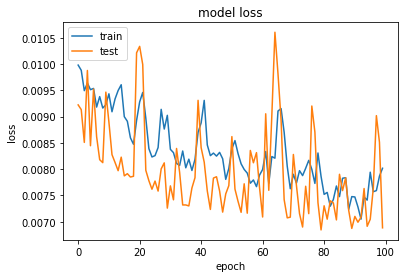

In [50]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

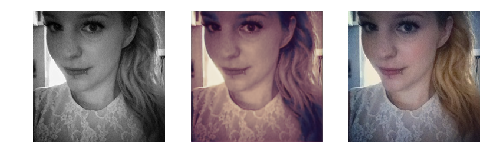

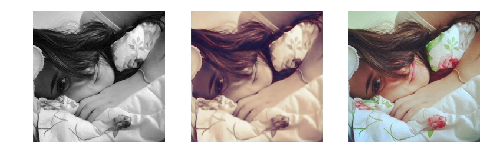

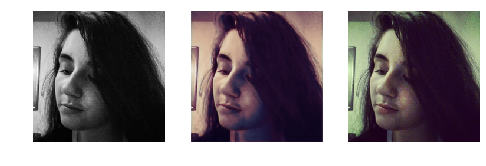

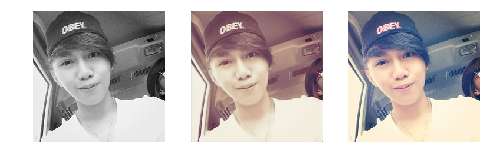

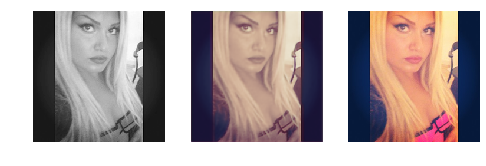

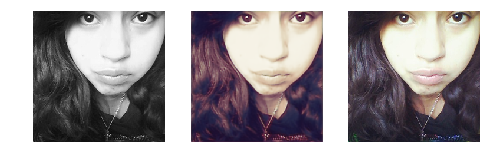

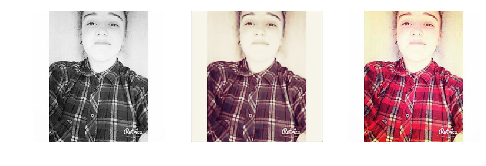

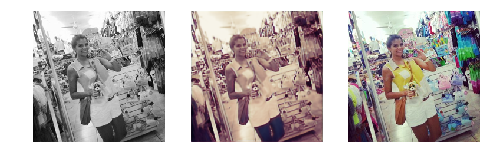

In [51]:

for id in range(8):
    fig = plt.figure(figsize=(8, 4))
    fig.add_subplot(1, 3, 1)
    plt.imshow(X[id], cmap='gray')
    plt.axis('off')
    fig.add_subplot(1, 3, 2)
    plt.imshow(np.uint8(model.predict(X_scaled[id:id+1])[0]*255))
    plt.axis('off')
    fig.add_subplot(1, 3, 3)
    plt.imshow(np.uint8(y_scaled[id]*255))
    plt.axis('off')
    plt.show()

In [15]:
model.save('coloRayzor.h5')